## Import Libraries

In [12]:
import pandas as pd
import numpy as np
import numpy as np
import pandas as pd
import random
import os
import time
from tempfile import TemporaryDirectory



import matplotlib.pyplot as plt
import matplotlib.patches as patches

import cv2

from PIL import Image
from collections import defaultdict
from typing import Dict, Tuple, List, Any
import math

import webcolors

#For boxplots
import seaborn as sns

from skimage.measure import shannon_entropy
from sklearn.cluster import KMeans

from dataclasses import dataclass

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader


## Load Dataset

In [13]:
@dataclass(frozen=True)
class Constants:
    POTATO_IMAGES_FOLDER_NAME_STR = "potato_images"

CONST = Constants()


# Exploratory Data Analysis (EDA)


## EDA (Count and Category)

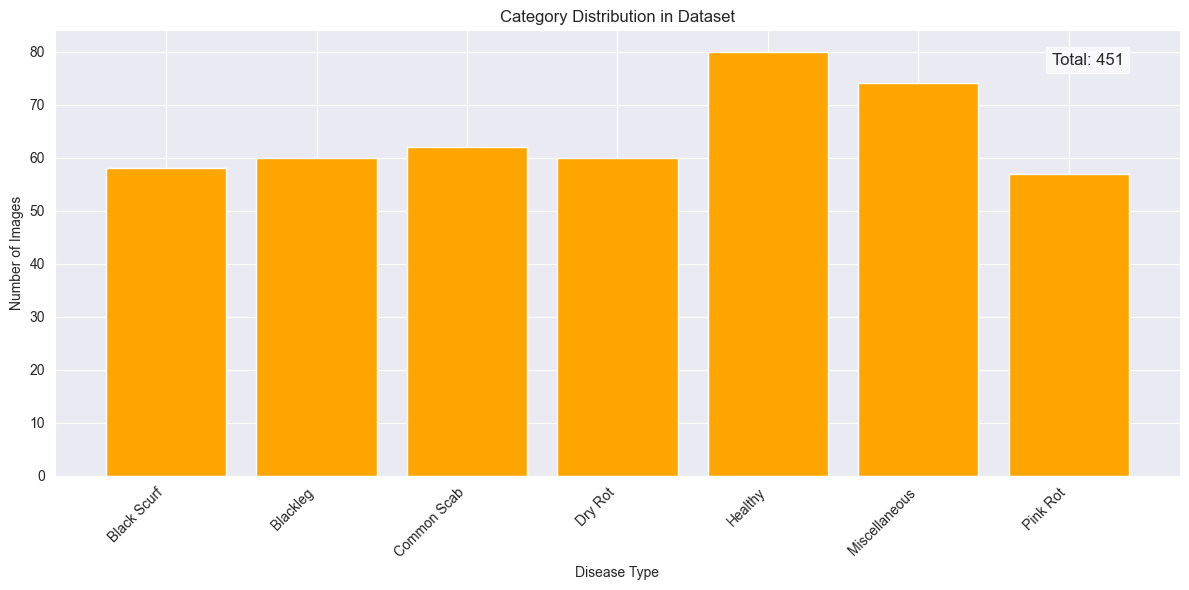

In [14]:
#EDA-Tasks
categories_list = os.listdir(CONST.POTATO_IMAGES_FOLDER_NAME_STR)


category_count_dict = {}
for category_str in categories_list:
    category_path = os.path.join(CONST.POTATO_IMAGES_FOLDER_NAME_STR, category_str)
    file_count_int = len(os.listdir(category_path))
    category_count_dict[category_str] = file_count_int

#Adding a figure that shows the distribution of images
total_images_int = sum(category_count_dict.values())
plt.figure(figsize=(12, 6))
plt.bar(category_count_dict.keys(), category_count_dict.values(), color='orange')
plt.title("Category Distribution in Dataset")
plt.xlabel("Disease Type")
plt.ylabel("Number of Images")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

#Add total number of images in the top right corner
plt.text(0.95, 0.95, f"Total: {total_images_int}", transform=plt.gca().transAxes,
         ha='right', va='top', fontsize=12, bbox=dict(facecolor='white', alpha=0.7))

plt.show()


## EDA (Resolution)

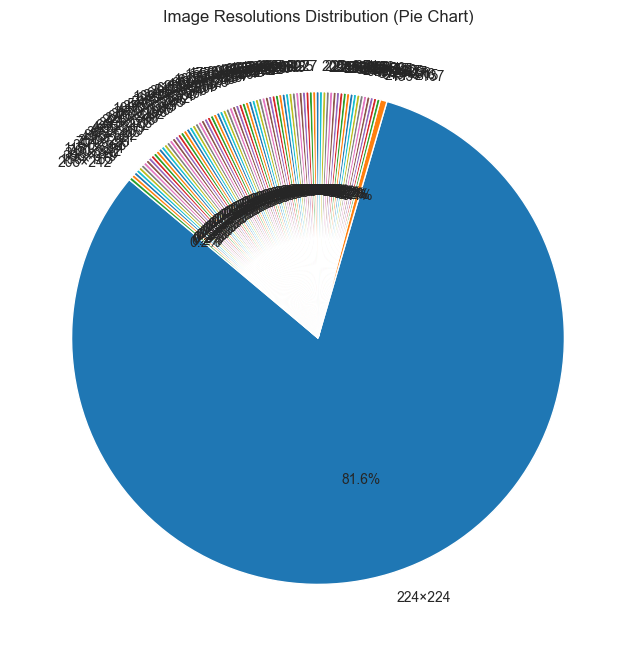

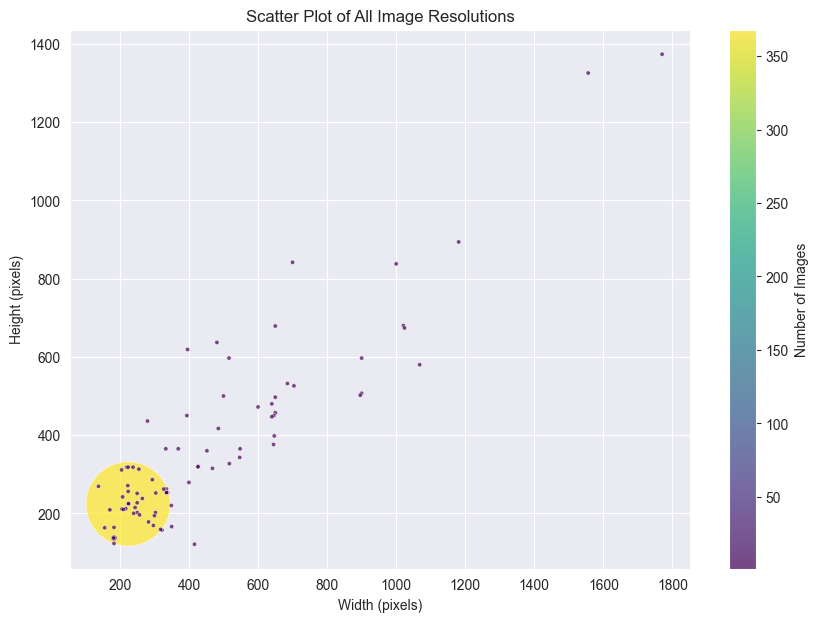

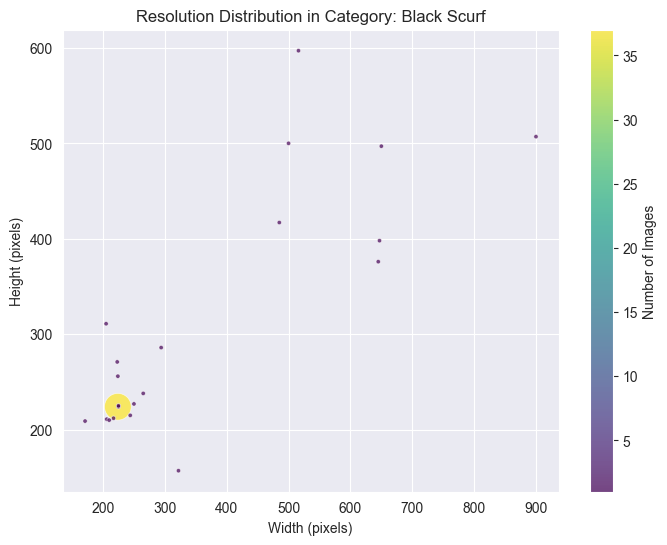

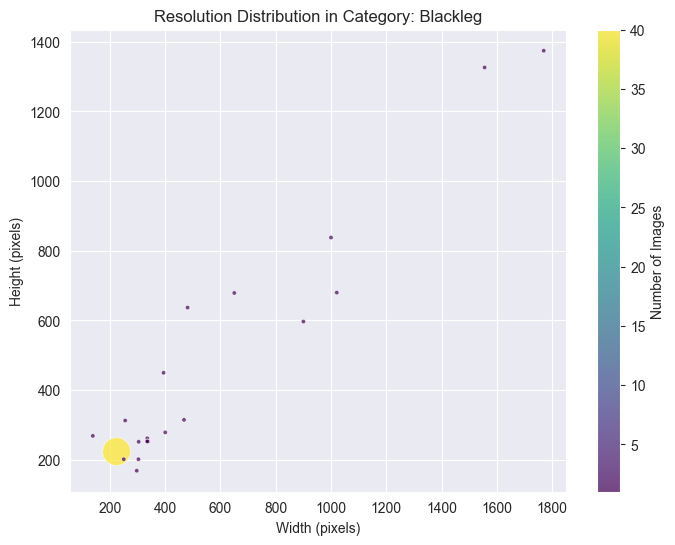

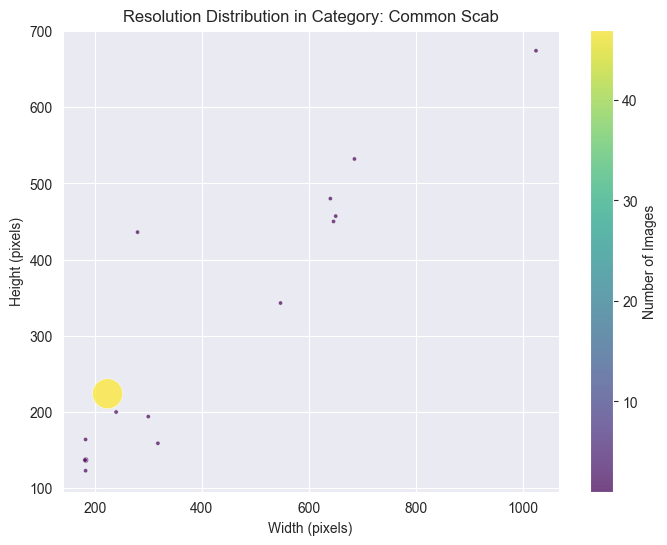

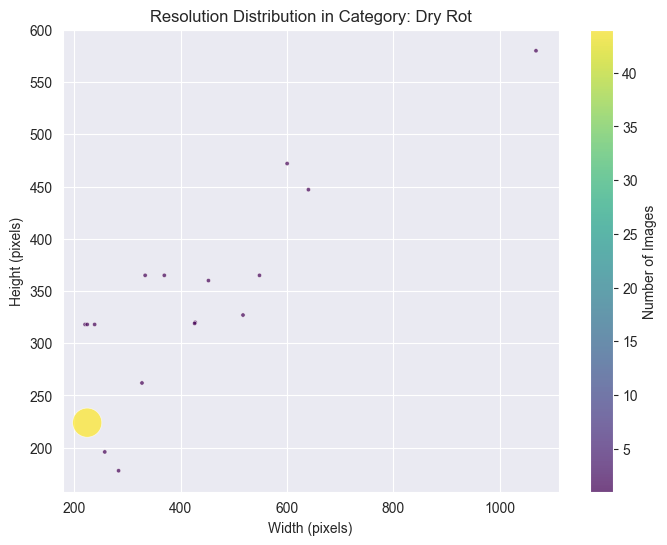

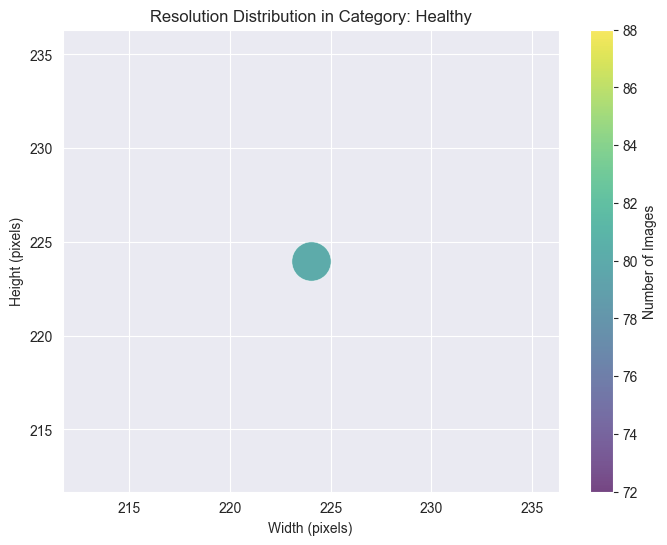

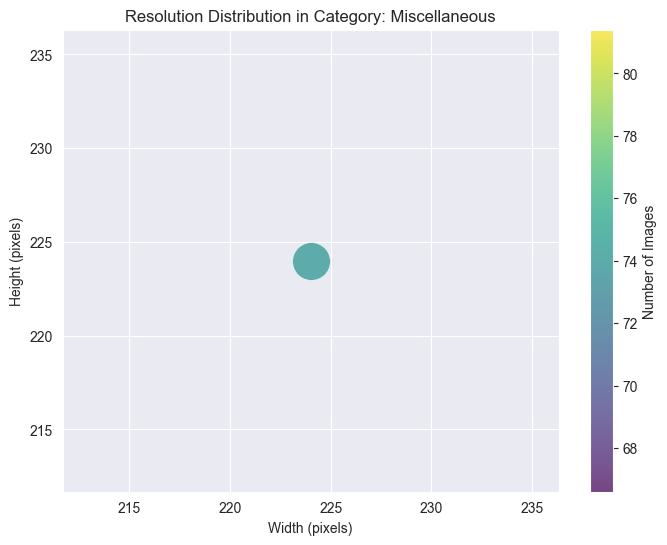

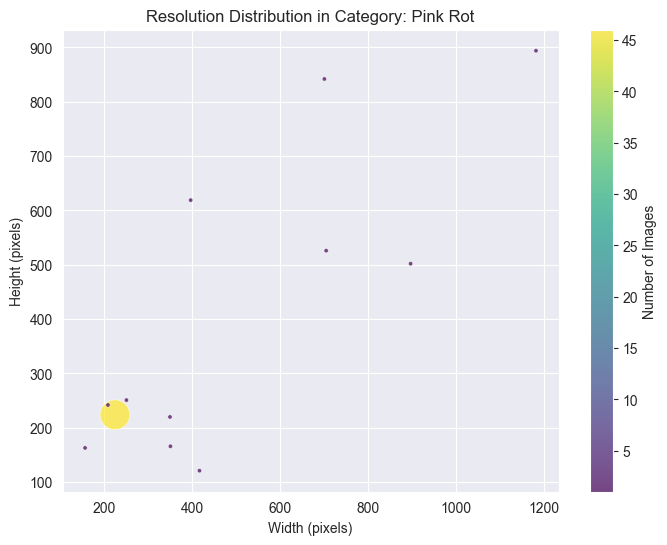

In [15]:
# Collect image resolutions + categories
resolution_list: List[Tuple[int, int]] = []
resolution_category_map: Dict[Tuple[int, int], Dict[str, int]] = defaultdict(lambda: defaultdict(int))

for root_str, _, file_name_list in os.walk(CONST.POTATO_IMAGES_FOLDER_NAME_STR):
    for file_name_str in file_name_list:
        if file_name_str.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif', '.webp')):
            try:
                image_path_str = os.path.join(root_str, file_name_str)
                with Image.open(image_path_str) as image_obj:
                    resolution_tuple = image_obj.size  # (width_int, height_int)
                    category_str = os.path.basename(root_str)

                    resolution_list.append(resolution_tuple)
                    resolution_category_map[resolution_tuple][category_str] += 1
            except Exception as exception_obj:
                print(f"[Warning] Could not process '{file_name_str}': {exception_obj}")

# Count total resolutions
resolution_count_dict: Dict[Tuple[int, int], int] = defaultdict(int)
for resolution_tuple in resolution_list:
    resolution_count_dict[resolution_tuple] += 1

# Check total count and throw error if the sum from before doesnt match
overall_count_int = sum(resolution_count_dict.values())
if overall_count_int != total_images_int:
    raise ValueError(f"Mismatch in image count: counted {overall_count_int}, expected {total_images_int}")

# Prepare the data for the pie chart
sorted_resolution_items = sorted(resolution_count_dict.items(), key=lambda x: x[1], reverse=True)
label_list = [f"{width_int}×{height_int}" for (width_int, height_int), _ in sorted_resolution_items]
count_list = [count_int for _, count_int in sorted_resolution_items]

# Draw the pie chart showing all resolutions and their count / frequencies
plt.figure(figsize=(8, 8))
plt.pie(count_list, labels=label_list, autopct='%1.1f%%', startangle=140)
plt.title("Image Resolutions Distribution (Pie Chart)")
plt.show()

# Helper function to extract the integer values into lists for later use in the scatter plot
def get_scatter_data(resolution_count_dict: Dict[Tuple[int, int], int]) -> Tuple[List[int], List[int], List[int]]:
    resolution_width_list = [resolution_tuple[0] for resolution_tuple in resolution_count_dict]
    resolution_height_list = [resolution_tuple[1] for resolution_tuple in resolution_count_dict]
    resolution_frequency_list = [resolution_count_dict[resolution_tuple] for resolution_tuple in resolution_count_dict]
    return resolution_width_list, resolution_height_list, resolution_frequency_list

# Draw a scatter plot showing the resolution distribution over all categories
widths_list, heights_list, frequencies_list = get_scatter_data(resolution_count_dict)
plt.figure(figsize=(10, 7))
scatter = plt.scatter(widths_list, heights_list, s=[f * 10 for f in frequencies_list],
                      c=frequencies_list, cmap='viridis', alpha=0.7, edgecolors='w', linewidth=0.5)
plt.colorbar(scatter, label='Number of Images')
plt.xlabel('Width (pixels)')
plt.ylabel('Height (pixels)')
plt.title('Scatter Plot of All Image Resolutions')
plt.grid(True)
plt.show()

# Invert mapping to category -> resolution -> count
category_resolution_map: Dict[str, Dict[Tuple[int, int], int]] = defaultdict(lambda: defaultdict(int))
for resolution_tuple, category_count_dict in resolution_category_map.items():
    for category_str, image_count_int in category_count_dict.items():
        category_resolution_map[category_str][resolution_tuple] += image_count_int

# Draw scatter plots for each category of potatoes showing their respective resolution distribution
for category_str, resolution_count_dict in category_resolution_map.items():
    widths_list, heights_list, frequencies_list = get_scatter_data(resolution_count_dict)
    # Make these smaller than the general to better distinguish between them
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(widths_list, heights_list, s=[f * 10 for f in frequencies_list],
                          c=frequencies_list, cmap='viridis', alpha=0.7, edgecolors='w', linewidth=0.5)
    plt.colorbar(scatter, label='Number of Images')
    plt.xlabel('Width (pixels)')
    plt.ylabel('Height (pixels)')
    plt.title(f'Resolution Distribution in Category: {category_str}')
    plt.grid(True)
    plt.show()

## EDA (Background Colors)


In [16]:
#test

## EDA (Brightness and Color)

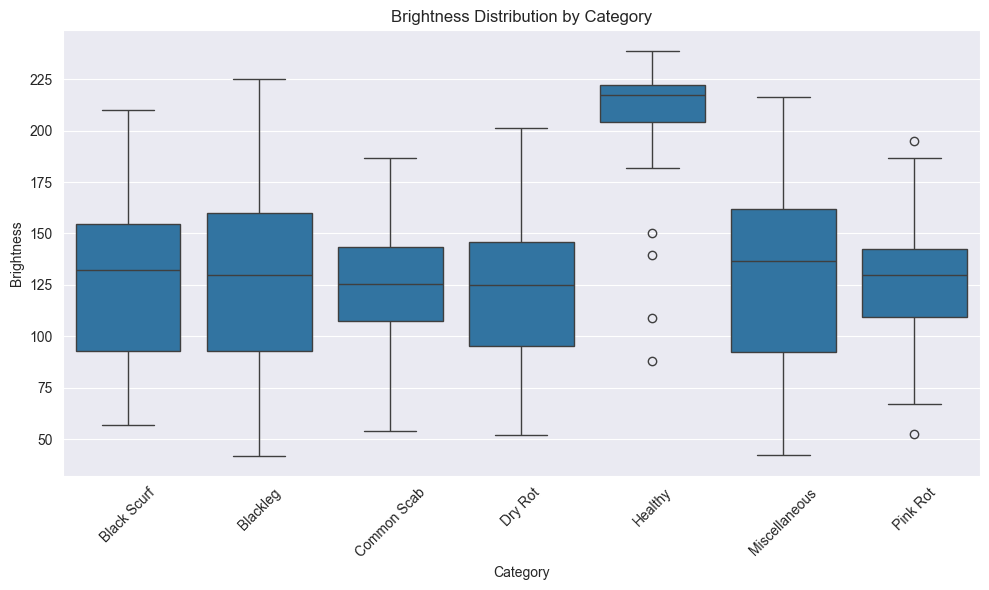

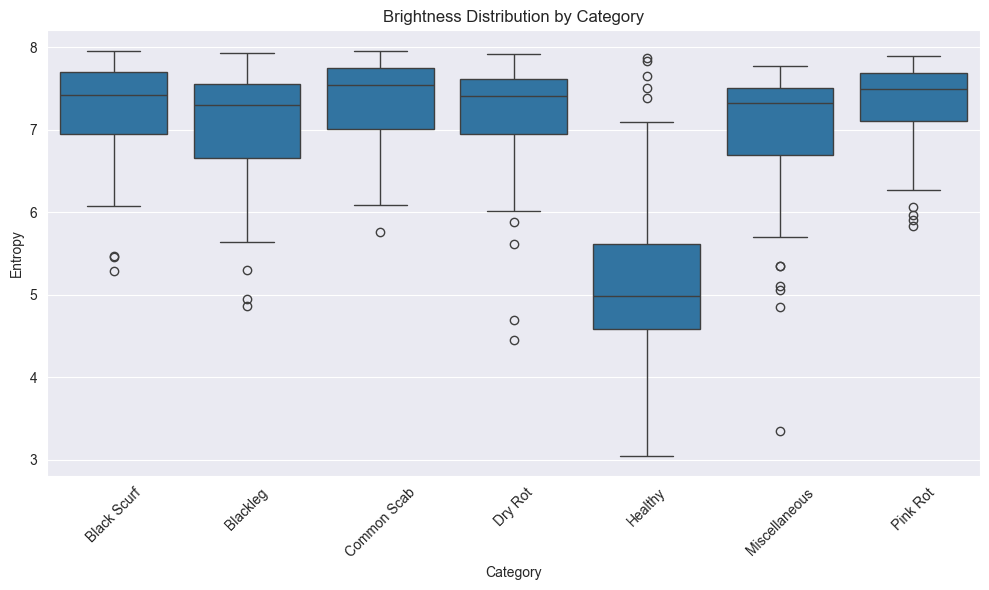

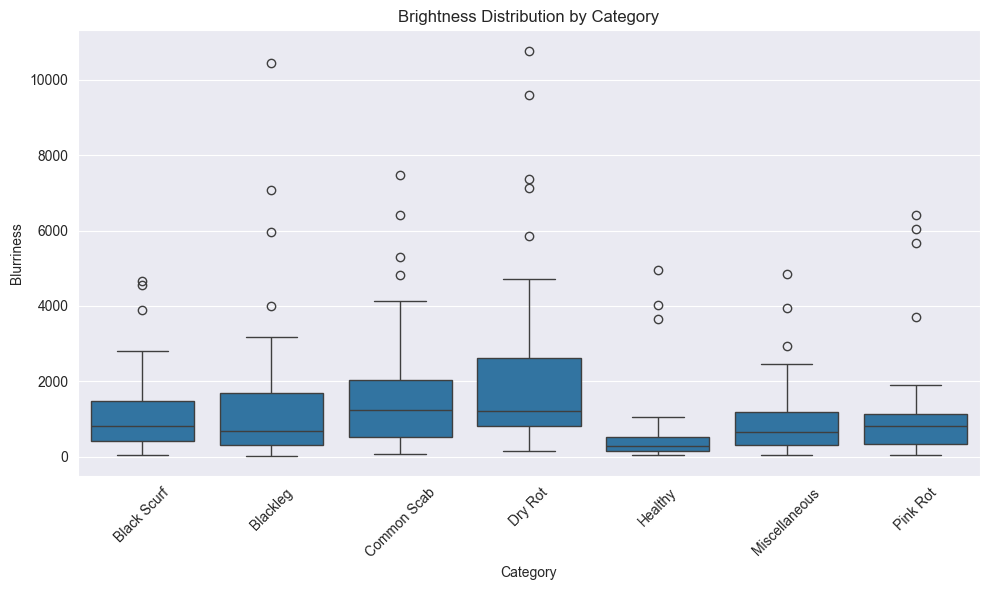

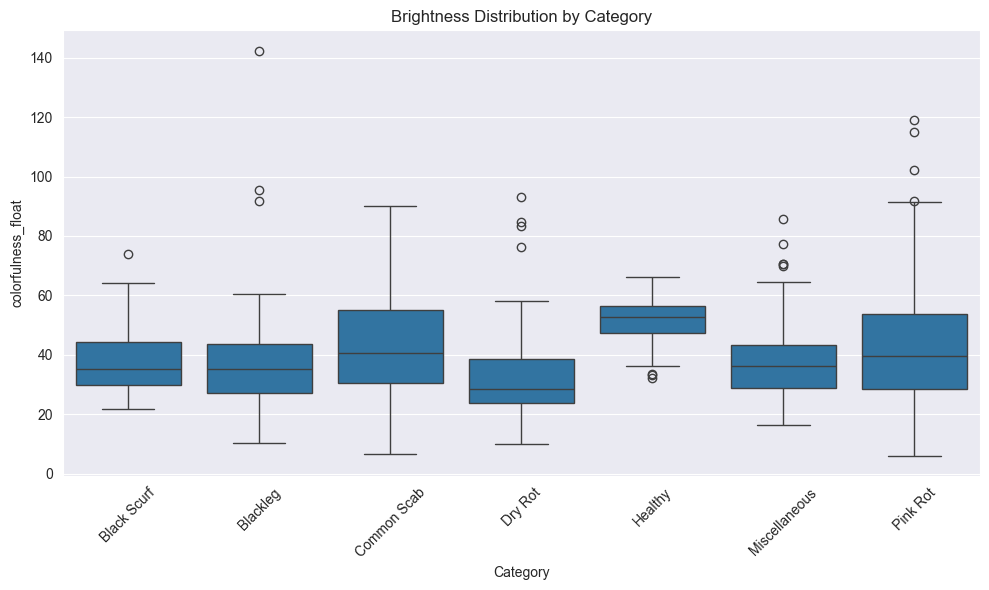

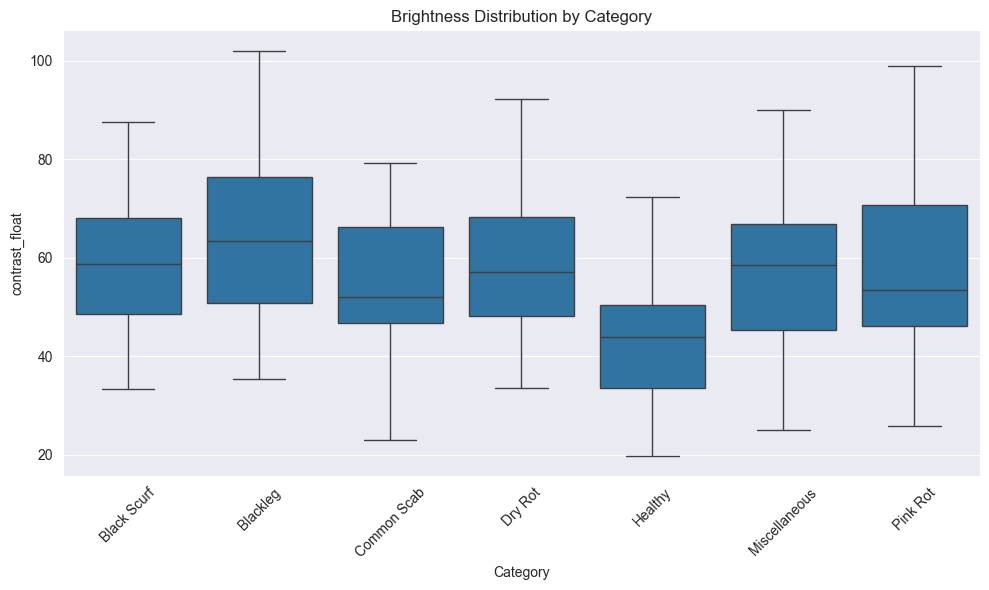

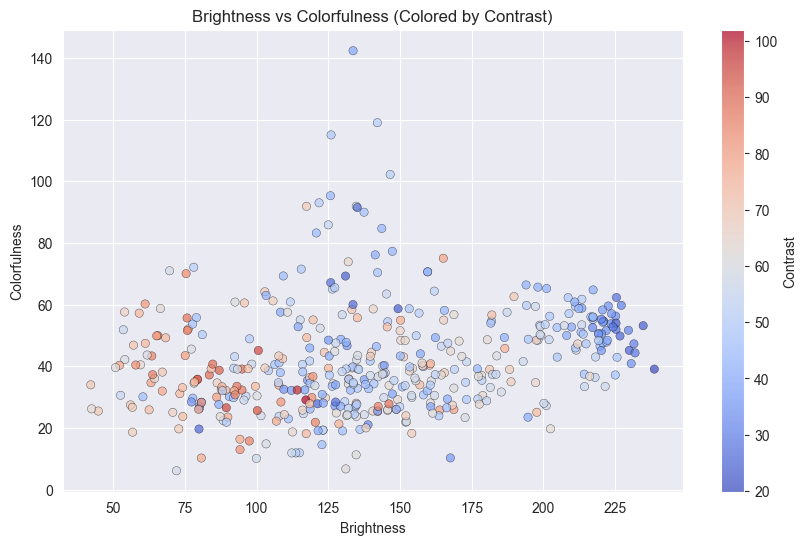

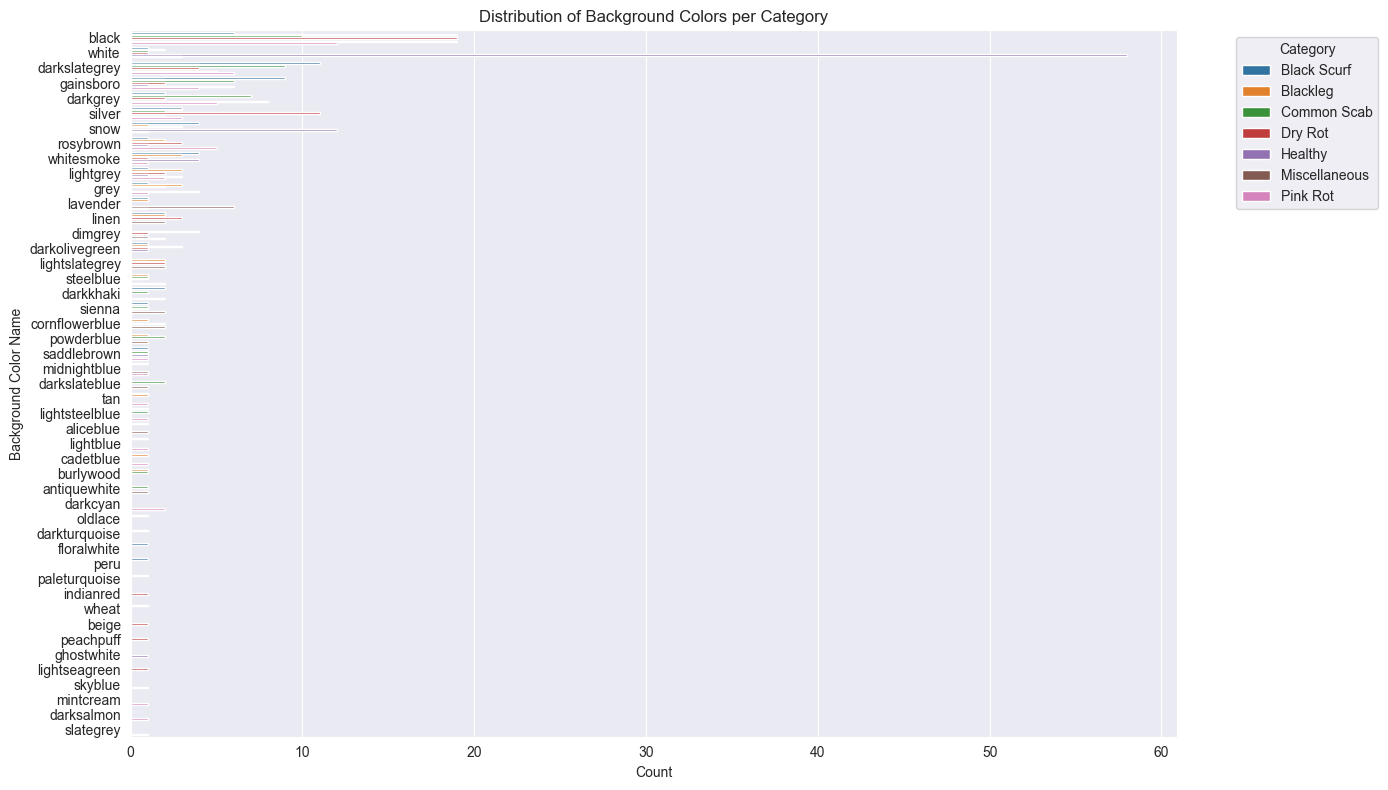

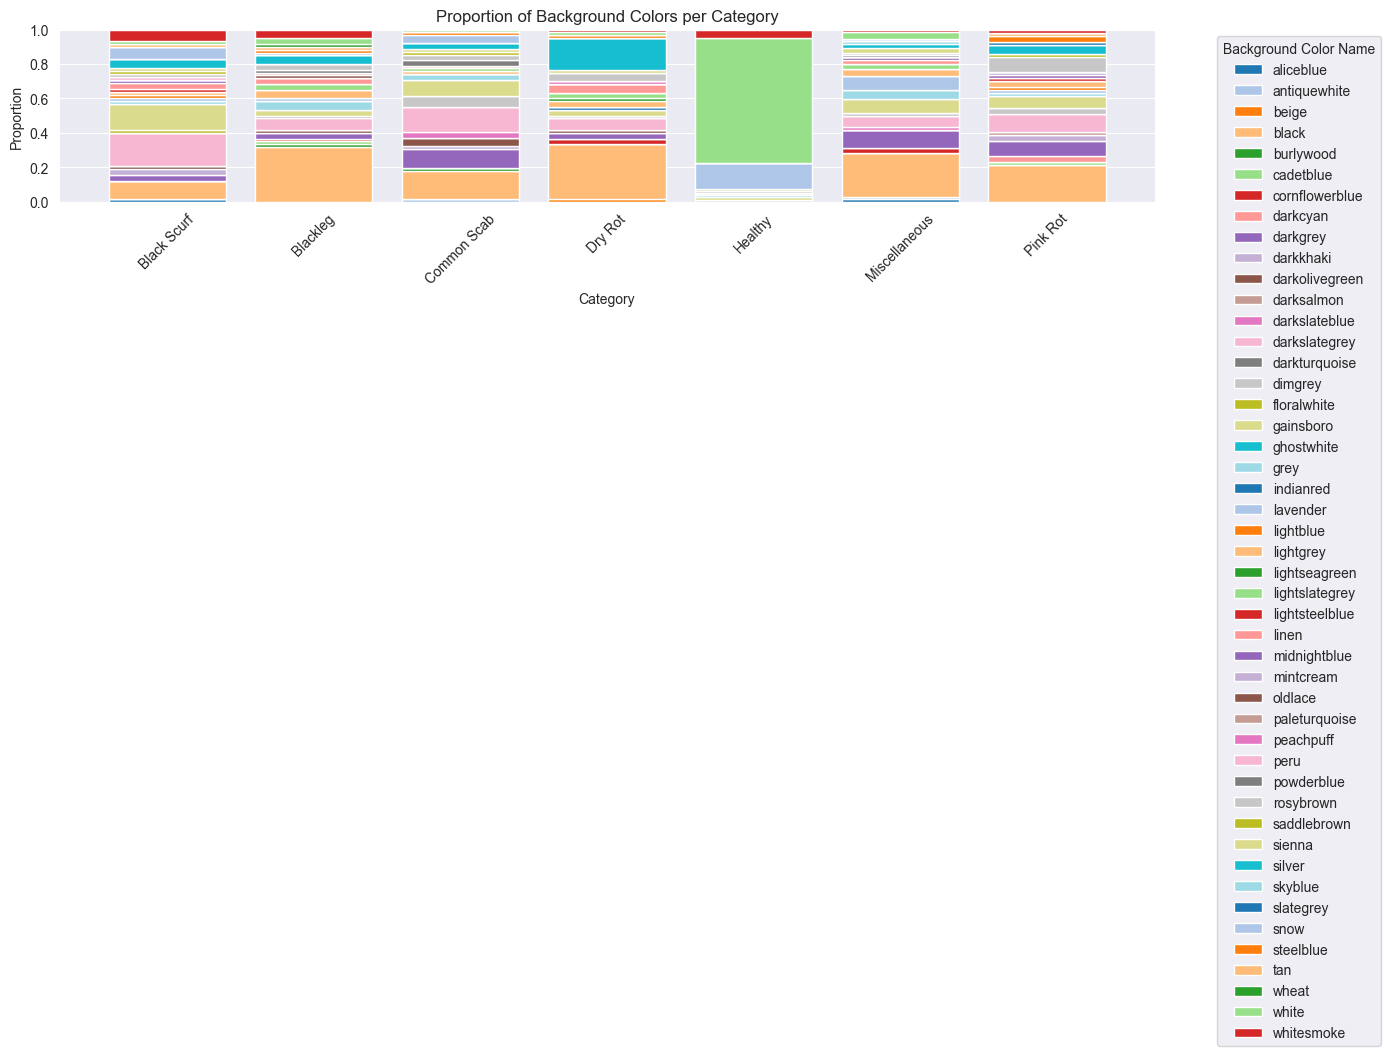

In [17]:

def calculate_blurriness(image_np: np.ndarray) -> float:
    gray = cv2.cvtColor(image_np, cv2.COLOR_RGB2GRAY)
    return float(cv2.Laplacian(gray, cv2.CV_64F).var())

def calculate_entropy(image_np: np.ndarray) -> float:
    return float(shannon_entropy(image_np))

def calculate_colorfulness(image_np: np.ndarray) -> float:
    # RG = R - G
    rg = image_np[..., 0].astype(float) - image_np[..., 1].astype(float)
    # YB = 0.5 * (R + G) - B
    yb = 0.5 * (image_np[..., 0].astype(float) + image_np[..., 1].astype(float)) - image_np[..., 2].astype(float)
    rg_std = np.std(rg)
    yb_std = np.std(yb)
    colorfulness_float = np.sqrt(rg_std**2 + yb_std**2)
    return colorfulness_float

def calculate_contrast(image_np: np.ndarray) -> float:
    # Umwandlung in Graustufen mit gewichteten RGB
    gray_data = np.dot(image_np[..., :3], [0.299, 0.587, 0.114])
    contrast_float = np.std(gray_data)
    return contrast_float

def closest_css3_color(requested_colour):
    min_colours = {}
    for name in webcolors.names("css3"):
        r_c, g_c, b_c = webcolors.name_to_rgb(name)
        rd = (r_c - requested_colour[0]) ** 2
        gd = (g_c - requested_colour[1]) ** 2
        bd = (b_c - requested_colour[2]) ** 2
        min_colours[(rd + gd + bd)] = name
    return min_colours[min(min_colours.keys())]

def safe_kmeans(pixels, n_clusters=2):
    unique_pixels = np.unique(pixels, axis=0)
    n_unique = unique_pixels.shape[0]

    # If fewer unique points than requested clusters, reduce clusters to number of unique points
    n_clusters = min(n_clusters, n_unique)
    if n_clusters == 0:
        raise ValueError("No pixels to cluster.")

    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init='auto')
    kmeans.fit(pixels)
    return kmeans

def estimate_background_color(image_np: np.ndarray, edge_thickness: int = 30, k: int = 2) -> Tuple[float, float, float]:
    h, w, _ = image_np.shape
    edge = min(edge_thickness, h // 5, w // 5)

    top = image_np[:edge, :, :]
    bottom = image_np[-edge:, :, :]
    left = image_np[:, :edge, :]
    right = image_np[:, -edge:, :]

    border_pixels = np.vstack([
        top.reshape(-1, 3),
        bottom.reshape(-1, 3),
        left.reshape(-1, 3),
        right.reshape(-1, 3)
    ])

    kmeans = safe_kmeans(border_pixels, n_clusters=k)
    labels = kmeans.labels_
    counts = np.bincount(labels)
    dominant_color = kmeans.cluster_centers_[np.argmax(counts)]

    return tuple(dominant_color)



# Create a list of image metadata for exploratory analysis
image_metadata_list: List[Dict[str, Any]] = []

for root_str, _, file_name_list in os.walk(CONST.POTATO_IMAGES_FOLDER_NAME_STR):
    for file_name_str in file_name_list:
        if file_name_str.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif', '.webp')):
            try:
                image_path_str = os.path.join(root_str, file_name_str)
                category_str = os.path.basename(root_str)

                with Image.open(image_path_str) as img:
                    img = img.convert('RGB')
                    image_np = np.array(img)

                    brightness = float(np.mean(image_np))
                    blurriness = calculate_blurriness(image_np)
                    entropy = calculate_entropy(image_np)
                    colorfulness = calculate_colorfulness(image_np)
                    contrast = calculate_contrast(image_np)
                    background_r, background_g, background_b = estimate_background_color(image_np)



                    metadata = {
                        'file_name_str': file_name_str,
                        'category_str': category_str,
                        'brightness_float': brightness,
                        'blurriness_float': blurriness,
                        'entropy_float': entropy,
                        'colorfulness_float': colorfulness,
                        'contrast_float': contrast,
                        'background_r': background_r,
                        'background_g': background_g,
                        'background_b': background_b,
                    }

                    image_metadata_list.append(metadata)

            except Exception as e:
                print(f"[Warning] Failed processing {file_name_str}: {e}")


image_metadata_df = pd.DataFrame(image_metadata_list)

image_metadata_df['background_color_name'] = image_metadata_df.apply(
    lambda row: closest_css3_color((
        int(row['background_r']),
        int(row['background_g']),
        int(row['background_b'])
    )),
    axis=1
)

plt.figure(figsize=(10, 6))
sns.boxplot(data=image_metadata_df, x='category_str', y='brightness_float')
plt.title('Brightness Distribution by Category')
plt.ylabel('Brightness')
plt.xlabel('Category')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


plt.figure(figsize=(10, 6))
sns.boxplot(data=image_metadata_df, x='category_str', y='entropy_float')
plt.title('Entropy Distribution by Category')
plt.ylabel('Entropy')
plt.xlabel('Category')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(data=image_metadata_df, x='category_str', y='blurriness_float')
plt.title('Blurriness Distribution by Category')
plt.ylabel('Blurriness')
plt.xlabel('Category')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(data=image_metadata_df, x='category_str', y='colorfulness_float')
plt.title('Colorfulness Distribution by Category')
plt.ylabel('Colorfulness')
plt.xlabel('Category')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(data=image_metadata_df, x='category_str', y='contrast_float')
plt.title('Contrast Distribution by Category')
plt.ylabel('Contrast')
plt.xlabel('Category')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    [entry['brightness_float'] for entry in image_metadata_list],
    [entry['colorfulness_float'] for entry in image_metadata_list],
    c=[entry['contrast_float'] for entry in image_metadata_list],
    cmap='coolwarm', alpha=0.7, edgecolors='k', linewidth=0.3
)
plt.colorbar(scatter, label='Contrast')
plt.xlabel('Brightness')
plt.ylabel('Colorfulness')
plt.title('Brightness vs Colorfulness (Colored by Contrast)')
plt.grid(True)
plt.show()


# Use a bar graph to vizualize the frequency of different colors
plt.figure(figsize=(14, 8))
sns.countplot(
    data=image_metadata_df,
    y='background_color_name',
    hue='category_str',
    order=image_metadata_df['background_color_name'].value_counts().index
)
plt.title('Distribution of Background Colors per Category')
plt.xlabel('Count')
plt.ylabel('Background Color Name')
plt.legend(title='Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


contingency = pd.crosstab(image_metadata_df['category_str'], image_metadata_df['background_color_name'])

# Normalize per category
contingency_norm = contingency.div(contingency.sum(axis=1), axis=0)

# Sort columns alphabetically to keep consistent order
contingency_norm = contingency_norm.reindex(sorted(contingency_norm.columns), axis=1)

categories = contingency_norm.index.tolist()
colors = plt.cm.tab20.colors  # You can pick any colormap you like

fig, ax = plt.subplots(figsize=(14, 7))

bottom = np.zeros(len(categories))

# Plot each background color as a stacked bar
for i, color_name in enumerate(contingency_norm.columns):
    values = contingency_norm[color_name].values
    ax.bar(categories, values, bottom=bottom, color=colors[i % len(colors)], label=color_name)
    bottom += values

ax.set_xlabel('Category')
ax.set_ylabel('Proportion')
ax.set_title('Proportion of Background Colors per Category')
ax.legend(title='Background Color Name', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



## Data Cleaning & Preprocessing

In [18]:
#Data Processing

## Split Data into Train / Test


In [19]:
#Split Data

## Apply ML Model

In [20]:
Applying ML

SyntaxError: invalid syntax (2670711504.py, line 1)

## Evaluate Results



In [9]:
#Evaluate Results and compare different models

## Summary and Conclusion